# Media Mix Modeling 

# Introduction 
<font size=4 face='Times Roman'> Media Mix Modeling or Marketing Mix Modeling is used to measure how media spending contributions to sales. It also allows to act on future budget allocation. 
<br>
<font size=4 face='Times Roman'> PyMC Labs built this Bayesian MMM model based on [Google's paper](https://storage.googleapis.com/gweb-research2023-media/pubtools/pdf/b20467a5c27b86c08cceed56fc72ceadb875184a.pdf). This demo focuses on showing how does it work.
<br> This work is a brief version, but I will keep it updated, please stay tuned!

### Data Processing 

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns


from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation
from pymc_marketing.mmm.delayed_saturated_mmm import DelayedSaturatedMMM
from pymc_marketing.mmm.budget_optimizer import calculate_expected_contribution

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
warnings.filterwarnings("ignore")

# az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [3]:
plt.style.available
plt.style.use('seaborn-v0_8-pastel')

In [4]:
data = pd.read_csv(r'C:\Users\corad\OneDrive\ProjectDataset\mmm.csv', parse_dates=['Date'])

In [5]:
data.head()

,Date,TV,Radio,Banners,Sales
0,2018-01-07,13528.1,0.00,0.00,9779.80
1,2018-01-14,0.0,5349.65,2218.93,13245.19
2,2018-01-21,0.0,4235.86,2046.96,12022.66
3,2018-01-28,0.0,3562.21,0.00,8846.95
4,2018-02-04,0.0,0.00,2187.29,9797.07


* <font size= 2>***The sample data contains 3 media channels' spend: TV, Radio, and Banners; the sales; the date.***

In [6]:
n = data.shape[0]

In [7]:
data = data.assign(dayofyear=lambda x: x["Date"].dt.dayofyear)

In [8]:
data["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10) ** (1 / 4) - 1

* <font size= 2>***Adding synthetic trend to the data***

In [9]:
# fig, ax = plt.subplots()
# sns.lineplot(x="Date", y="seasonality", color="C2", label="trend", data=data, ax=ax)

### Data Modeling

In [10]:
X = data.drop("Sales",axis=1)
y = data["Sales"]

* <font size= 2>***Delayed Satrated MMM follows sklearn convention, so we split the data into X and y.***

In [11]:
mmm = DelayedSaturatedMMM(
    # model_config = my_model_config,
    # sampler_config = sampler_config,
    date_column="Date",
    channel_columns=["TV", "Radio",'Banners'],
    control_columns=["trend"],
    adstock_max_lag=8,
    yearly_seasonality=2,
    
)

* <font size= 2>***Fit the data into the model***

In [12]:
mmm.fit(X=X, y=y, target_accept=0.95, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_channel, alpha, lam, gamma_control, gamma_fourier, likelihood_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 219 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

In [13]:
mmm.fit_result

<xarray.Dataset>
Dimensions:                    (chain: 4, draw: 1000, control: 1,
                                fourier_mode: 4, channel: 3, date: 200)
Coordinates:
  * chain                      (chain) int32 0 1 2 3
  * draw                       (draw) int32 0 1 2 3 4 5 ... 995 996 997 998 999
  * control                    (control) <U5 'trend'
  * fourier_mode               (fourier_mode) <U11 'sin_order_1' ... 'cos_ord...
  * channel                    (channel) <U7 'TV' 'Radio' 'Banners'
  * date                       (date) datetime64[ns] 2018-01-07 ... 2021-10-31
Data variables: (12/13)
    intercept                  (chain, draw) float64 0.2634 0.2739 ... 0.2961
    gamma_control              (chain, draw, control) float64 0.0124 ... -0.0...
    gamma_fourier              (chain, draw, fourier_mode) float64 0.008281 ....
    beta_channel               (chain, draw, channel) float64 0.4751 ... 0.6069
    alpha                      (chain, draw, channel) float64 0.5035 ... 0.00075
    lam                        (chain, draw, channel) float64 3.068 ... 0.5572
    ...                         ...
    channel_adstock            (chain, draw, date, channel) float64 0.4851 .....
    channel_adstock_saturated  (chain, draw, date, channel) float64 0.6317 .....
    channel_contributions      (chain, draw, date, channel) float64 0.3001 .....
    control_contributions      (chain, draw, date, control) float64 0.009651 ...
    fourier_contributions      (chain, draw, date, fourier_mode) float64 0.00...
    mu                         (chain, draw, date) float64 0.5755 ... 0.4568
Attributes:
    created_at:                 2024-02-20T18:50:05.132009
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.10.3
    sampling_time:              218.72854161262512
    tuning_steps:               1000

In [14]:
az.summary(
    data=mmm.fit_result,
    var_names=[
        "intercept",
        "likelihood_sigma",
        "beta_channel",
        "alpha",
        "lam",
        "gamma_control",
        "gamma_fourier",
      
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.266,0.012,0.244,0.288,0.000,0.000,3294.0,2762.0,1.0
likelihood_sigma,0.028,0.001,0.025,0.030,0.000,0.000,4676.0,2898.0,1.0
beta_channel[TV],0.443,0.030,0.388,0.501,0.001,0.000,2937.0,2247.0,1.0
beta_channel[Radio],0.358,0.227,0.205,0.582,0.011,0.009,1366.0,615.0,1.0
beta_channel[Banners],0.396,0.259,0.165,0.808,0.006,0.004,2790.0,2121.0,1.0
alpha[TV],0.491,0.014,0.467,0.518,0.000,0.000,4367.0,2950.0,1.0
alpha[Radio],0.209,0.025,0.162,0.255,0.000,0.000,5237.0,2561.0,1.0
alpha[Banners],0.027,0.021,0.000,0.066,0.000,0.000,3458.0,1940.0,1.0
lam[TV],3.284,0.311,2.702,3.866,0.006,0.004,3156.0,2196.0,1.0
lam[Radio],2.035,0.607,0.709,3.093,0.018,0.012,1382.0,632.0,1.0


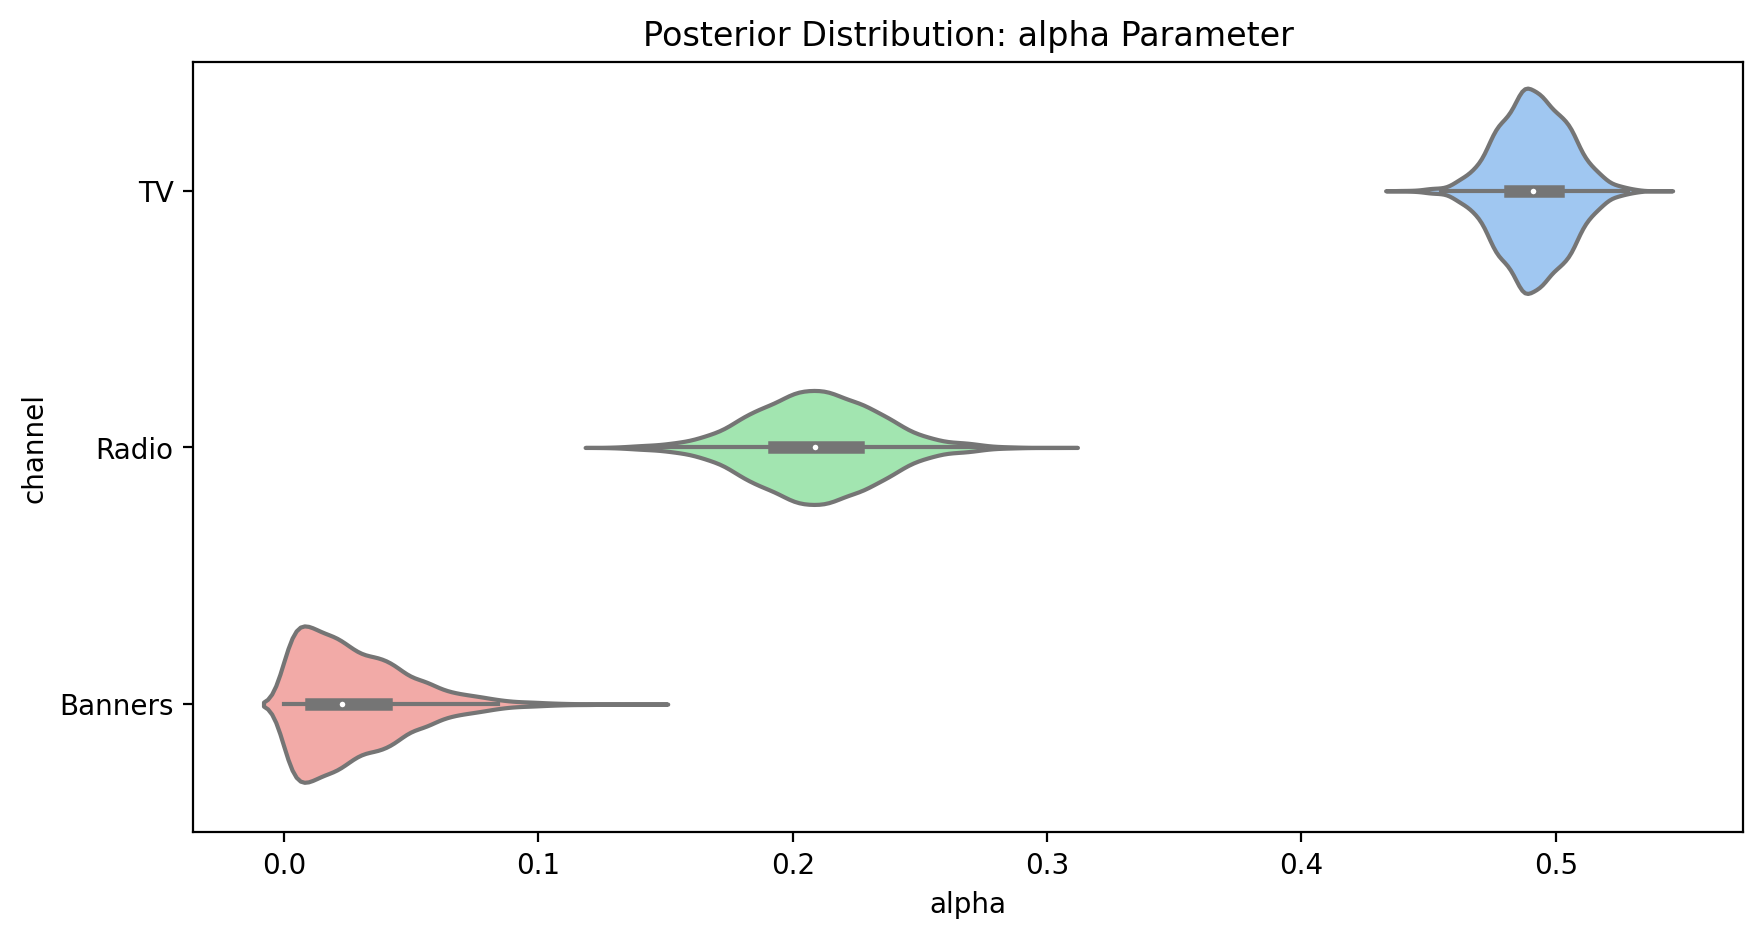

In [15]:
fig = mmm.plot_channel_parameter(param_name="alpha", figsize=(10, 5))

* <font size= 2>***The data was created with the carryover value for TV is 0.5, Radio for 0.2, and banners for 0.***
* <font size= 2>***The Pymc MMM model picked this up quite aligned as the table and chart showed above.***

In [16]:
mmm.sample_posterior_predictive(X, extend_idata=True, combined=True)

Sampling: [y]


<xarray.Dataset>
Dimensions:  (date: 200, sample: 4000)
Coordinates:
  * date     (date) datetime64[ns] 2018-01-07 2018-01-14 ... 2021-10-31
  * sample   (sample) object MultiIndex
  * chain    (sample) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int32 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
Data variables:
    y        (date, sample) float64 1.059e+04 9.869e+03 ... 8.968e+03 8.012e+03
Attributes:
    created_at:                 2024-02-20T18:50:07.958205
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.10.3

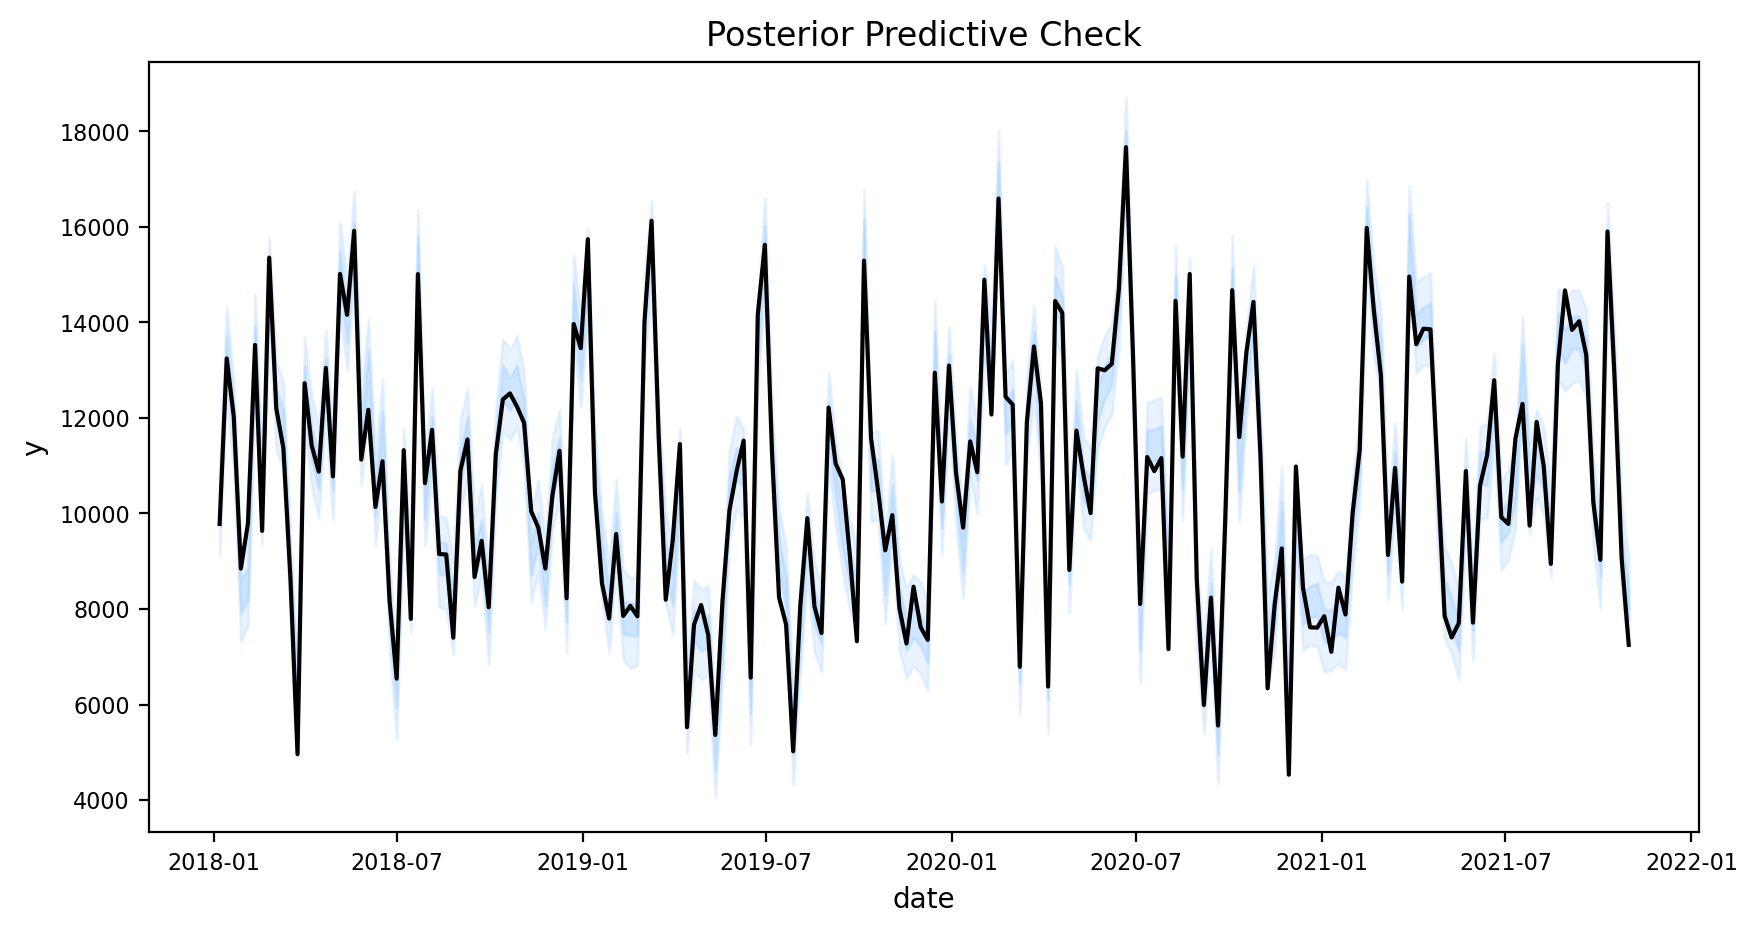

In [17]:
fig = mmm.plot_posterior_predictive(original_scale=True, figsize = (10,5))
# ax.tick_params(axis ='both', which ='major',  labelsize = 8) 
ax = fig.gca()

# Set tick parameters
ax.tick_params(axis='both', which='major', labelsize= 8)

plt.show()

* <font size= 2>***The black line is the model, and the blue line is sampling predictions. It looks like a good fit!***

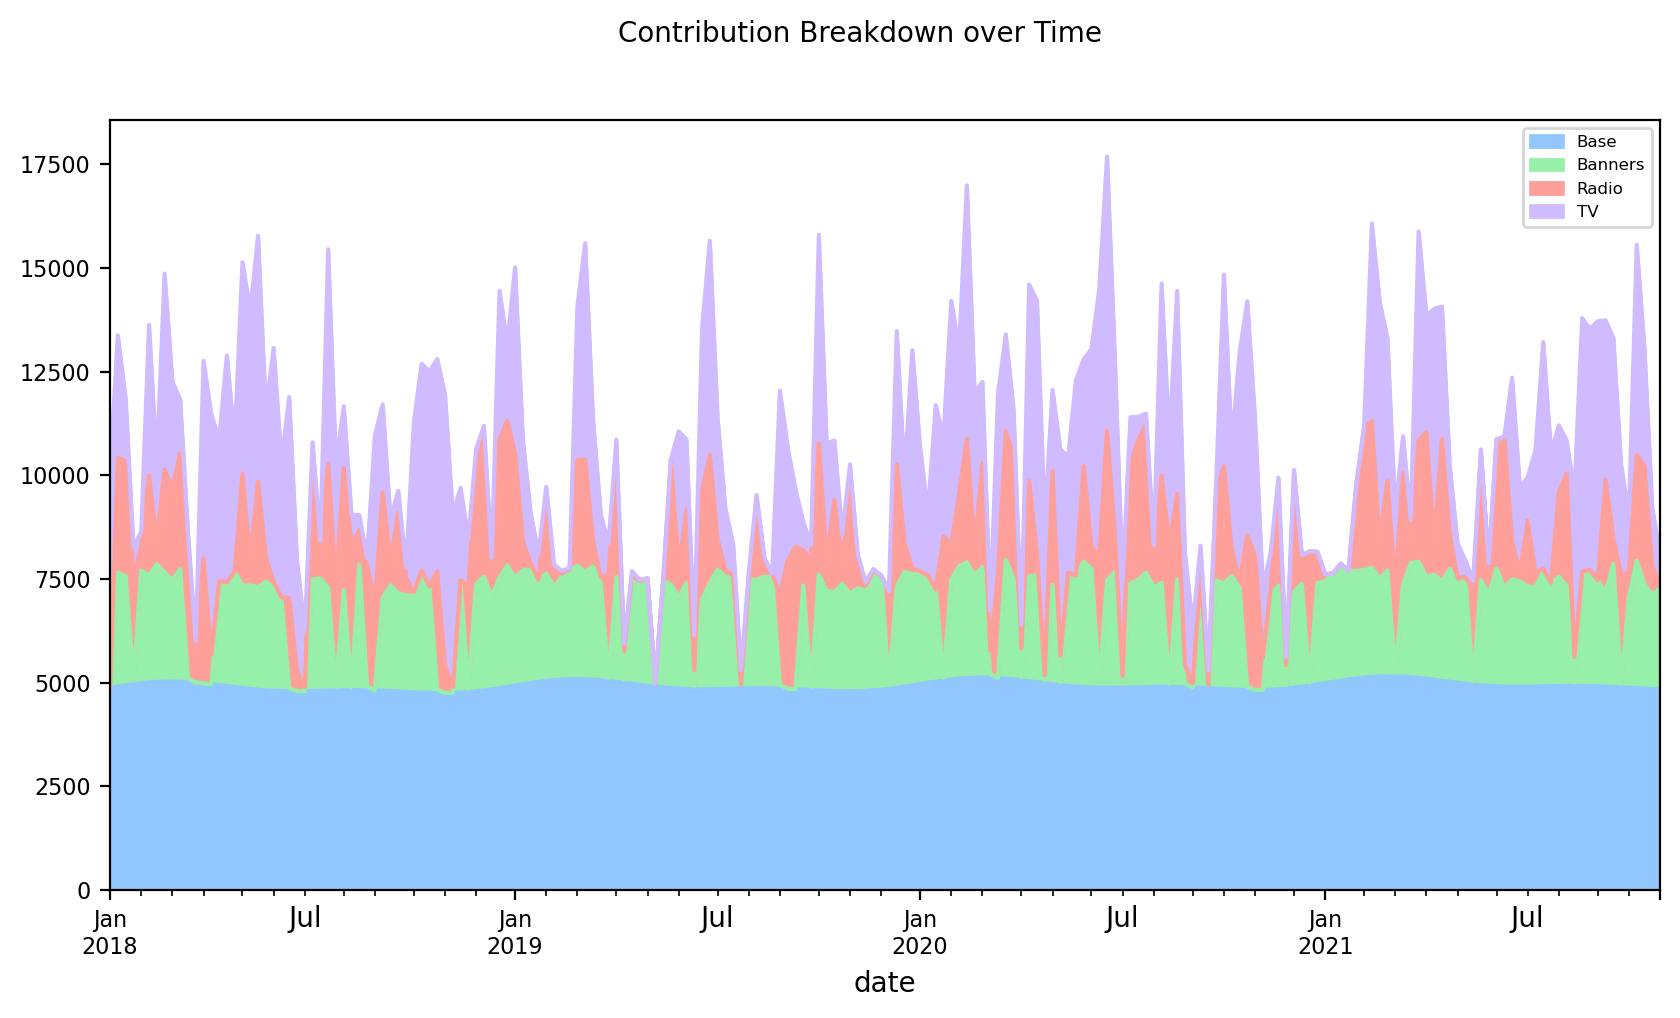

In [18]:
groups = {
    "Base": [
        "intercept",
        "trend",
        "sin_order_1",
        "sin_order_2",
        "cos_order_1",
        "cos_order_2",
       
    ],
    "Banners": ["Banners"],
    "Radio": ["Radio"],
    "TV": ["TV"],
}

fig = mmm.plot_grouped_contribution_breakdown_over_time(
    stack_groups=groups,
    original_scale=True,
    figsize = (10,5),
    
)
fig.suptitle("Contribution Breakdown over Time", fontsize=10);
# fig, ax = plt.subplots(figsize = (10,6))
ax = fig.gca()

# Set tick parameters
ax.tick_params(axis='both', which='major', labelsize= 8)
plt.legend(prop={'size': 6})

plt.show()

* <font size= 2>***We can also see a breakdown of base and channel contribution from the chart above.***

### Optimize Budget Allocation

In [19]:
sigmoid_params = mmm.compute_channel_curve_optimization_parameters_original_scale(method='sigmoid')
menten_params = mmm.compute_channel_curve_optimization_parameters_original_scale(method='michaelis-menten')

* <font size= 2>***Built the optimization parameters.***

In [20]:
# sigmoid_params, menten_params

In [21]:
total_budget = 50000 #Imagine is 5K or 5M
#Define your channels
channels = ['TV', 'Radio', 'Banners']
#The initial split per channel
budget_per_channel = total_budget / len(channels)
#Initial budget per channel as dictionary.
initial_budget_dict = {channel: budget_per_channel for channel in channels}
#bounds for each channel
min_budget, max_budget = 10000,50000
budget_bounds = {channel: [min_budget, max_budget] for channel in channels}

* <font size= 2>***Imagine our budget for next year is \\$50k, how can we use it to optimize the contribution from each marketing channel?***
* <font size= 2>***We are setting our total budget as \\$50k here, and the minimum budget for each marketing channel is \\$10k, the maximum budget for each channel is \\$50k.***

In [22]:
result_sigmoid = mmm.optimize_channel_budget_for_maximum_contribution(
    method = 'sigmoid', #define saturation function
    total_budget = total_budget,
    parameters = sigmoid_params,
    budget_bounds = budget_bounds
)

result_sigmoid

,estimated_contribution,optimal_budget
TV,10950.403789,25457.451458
Radio,6954.093599,14542.548542
Banners,8226.007027,10000.000000
total,26130.504415,50000.000000


* <font size= 2>***This table shows a breakdwon of how much budget we should put into each marketing channel.***

In [24]:
#Use the function `calculate_expected_contribution` to estimate
#the contribution of your initial budget based on the curve parameters.
initial_contribution = calculate_expected_contribution(
    method='sigmoid',
    parameters = sigmoid_params,
    budget = initial_budget_dict
)

# Initial budget & contribution dictionary
initial_scenario = {
    'initial_contribution': initial_contribution,
    'initial_budget': initial_budget_dict
}

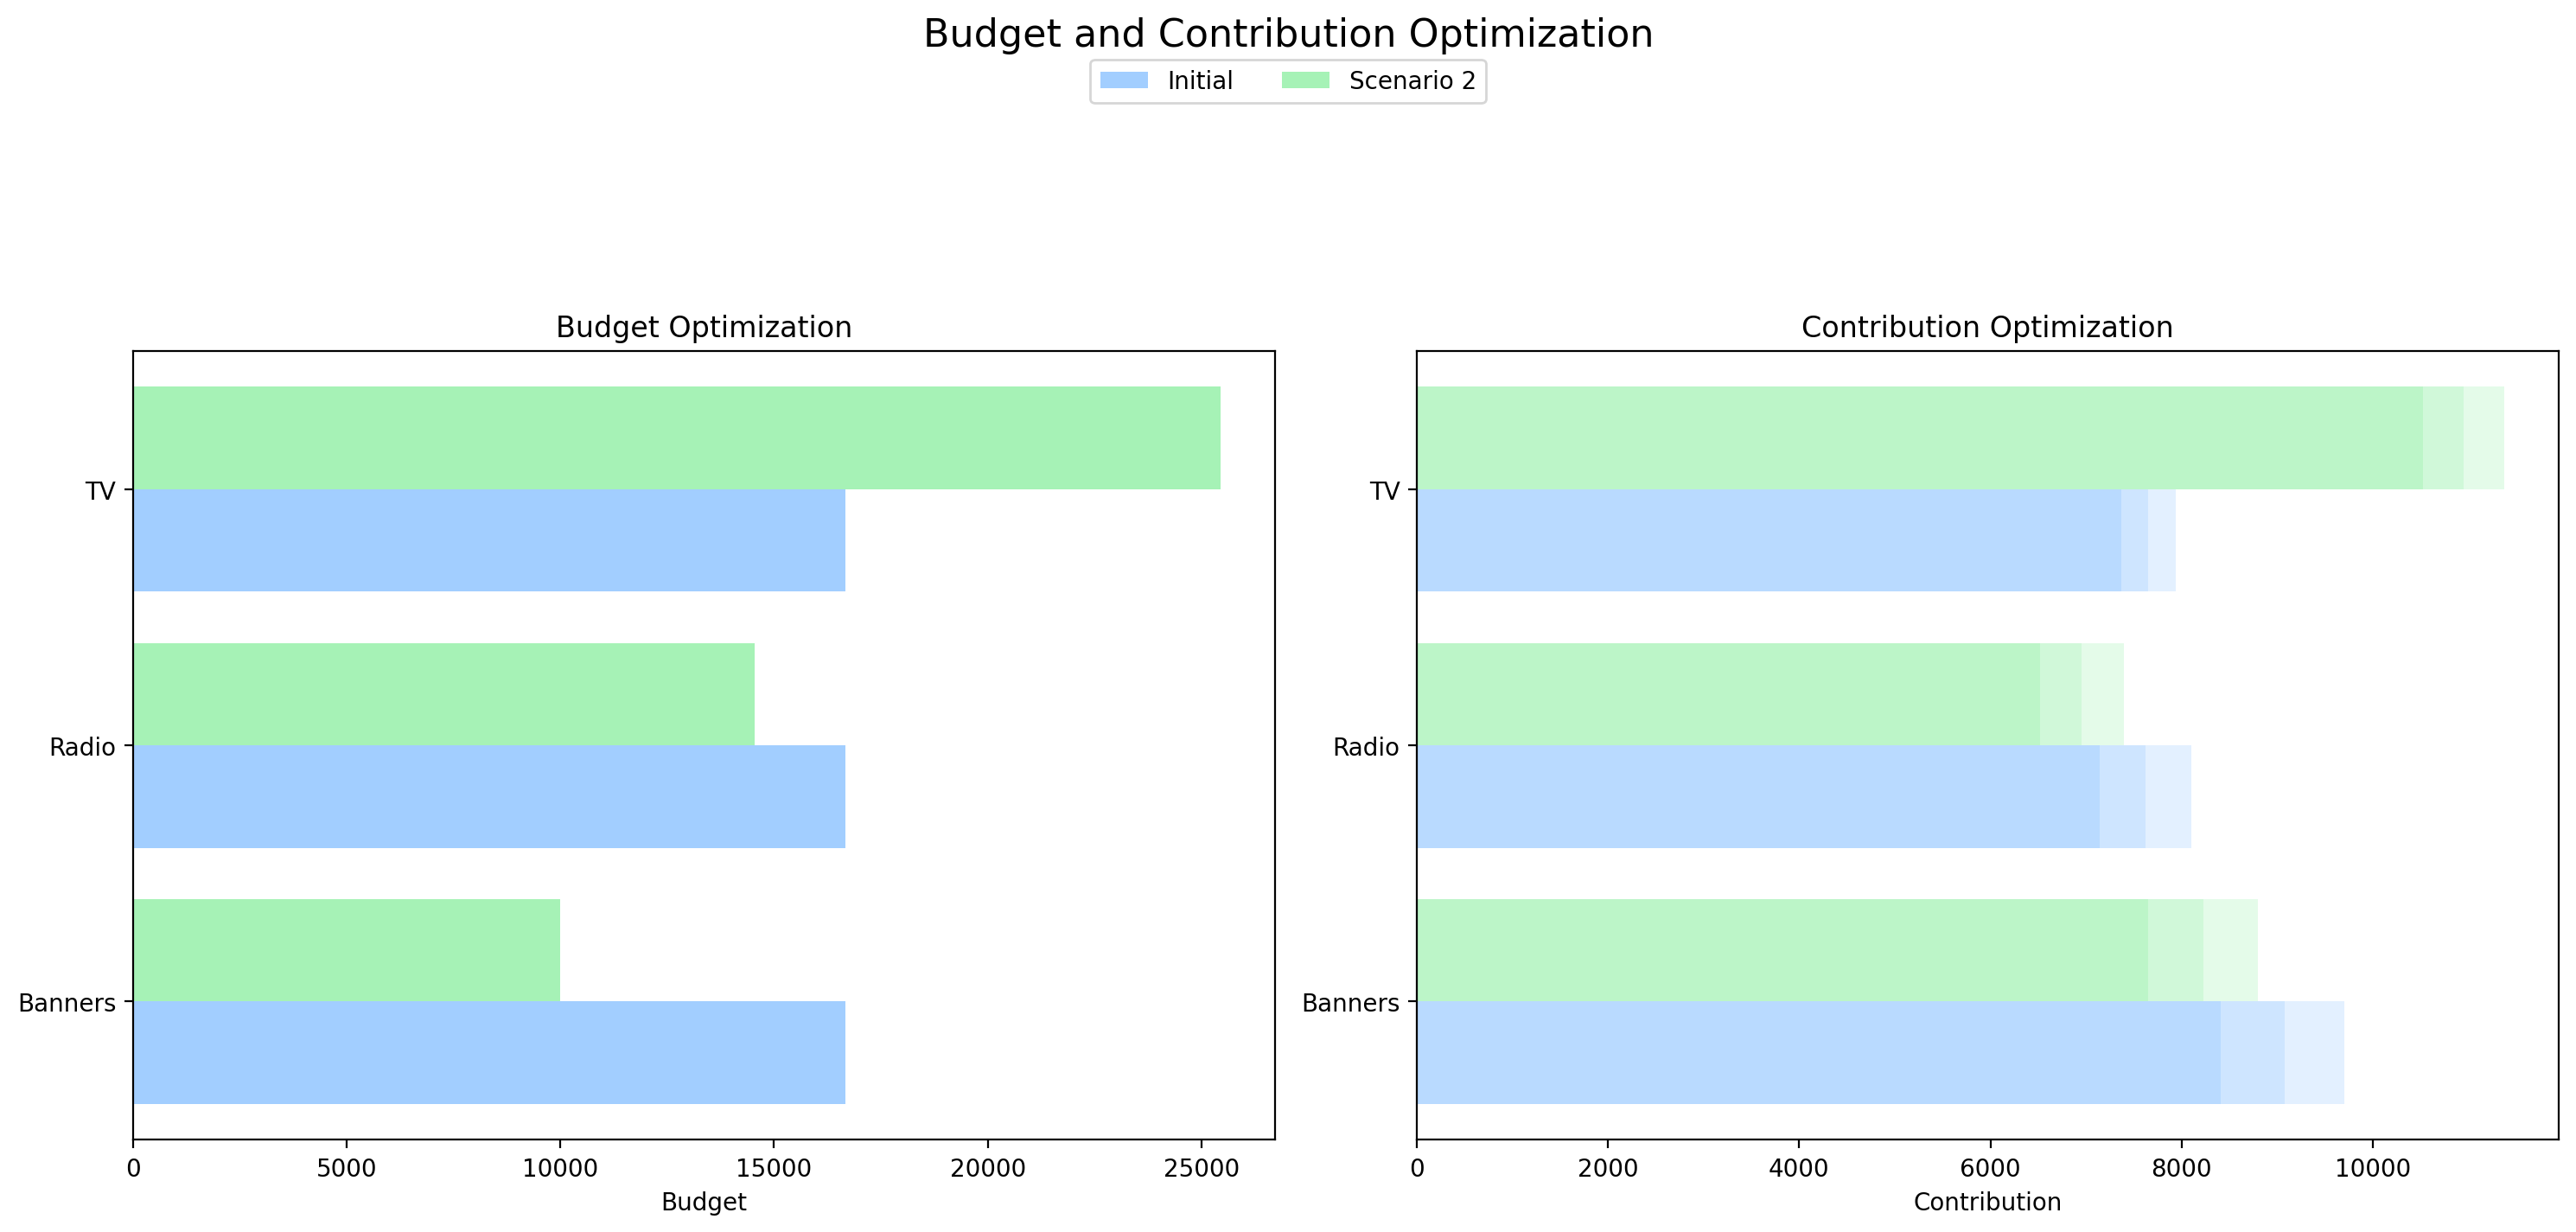

In [25]:
#Use the function `compare_budget_scenearios` to validate
#The estimated contribution from one scenario agains the other
figure_ = mmm.plot_budget_scenearios(base_data=initial_scenario, method='sigmoid', scenarios_data=[result_sigmoid])

* <font size= 2>***The chart on the left is showing us how the budget optimization look like. The right chart is showing us how the contribution optimization look like.***
* <font size= 2> ***In the left chart, we can see the before and after budget for each channel.***
* <font size= 2> ***In the right chart, we can see the before and after contribution optimization for each channel.***

### Conclusion

* <font size= 2> ***This MMM model built by Pymc Labs does provide actionable marketing insights.In the meantime, this model is still in the experimental stage.Therefore, the actionable insights should be used cautiously.***